[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_clean_data.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 5000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [888]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average housing area" and "per housing area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df.drop(["OBJECTCAT"], axis=1)
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  
  # Convert all strings to numeric
  df = df.convert_objects(convert_numeric=True)
  
  # Remove rows containing a "0", i.e price = 0 or rooms = 0
  df = df[~(df[["PRICE", "ROOMS","AREA"]] == 0)]
  
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  return df

In [890]:
df = clean_data(source)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [891]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
1,595000.0,7.209542,9.0,440.0,3.889550
5,299000.0,7.666556,5.0,140.0,3.332205
6,685000.0,7.497003,8.0,380.0,3.860730
8,206000.0,6.600842,1.0,280.0,5.634790
9,75000.0,7.114370,3.0,61.0,3.012262


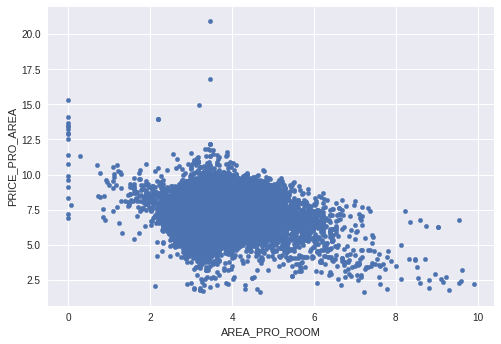

In [892]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [0]:
def make_dataset_and_labels_and_class_num(df, label_name):
  """This method will prepare da, labels for train, evaluation, test.
     Args:
      df: DataFrame format of datasource.
      label_name: The name of column in datasource which will be as target for train.
     Return: 
       Tuple of (ds_train, ds_eval, ds_test, label_train, label_eval, label_test)
      
  """
  target_label_col = label_name
   
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  label_train = ds_train[[target_label_col]]
  
  ds_rest = df.drop(ds_train.index)
  ds_rest = ds_rest.copy()
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  label_eval = ds_eval[[target_label_col]]
  
  ds_test = ds_rest.drop(ds_eval.index)
  label_test = ds_test[[target_label_col]]
  
  return ds_train[["AREA_PRO_ROOM"]], ds_eval[["AREA_PRO_ROOM"]], ds_test[["AREA_PRO_ROOM"]], label_train, label_eval, label_test

In [0]:
x_train, x_eval, x_test, y_train, y_eval, y_test = make_dataset_and_labels_and_class_num(df, "PRICE_PRO_AREA")

In [895]:
x_train.describe()

,AREA_PRO_ROOM
count,89726.000000
mean,3.452577
std,0.427495
min,0.000000
25%,3.218876
50%,3.397673
75%,3.604138
max,9.903488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f031d534780>]],
      dtype=object)

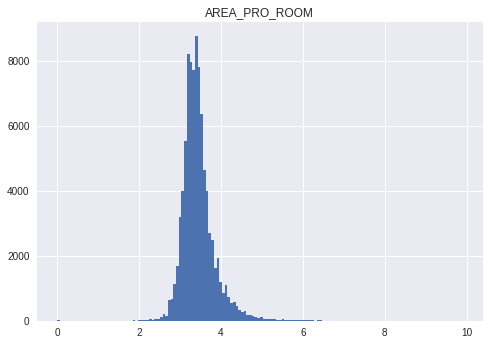

In [896]:
x_train.hist("AREA_PRO_ROOM", bins = BINS)

In [897]:
y_train.describe()

,PRICE_PRO_AREA
count,89726.000000
mean,7.523993
std,0.734977
min,1.629641
25%,7.130899
50%,7.561682
75%,7.965790
max,16.762453


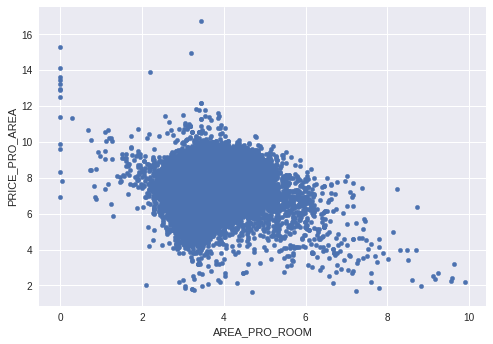

In [898]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [899]:
x_eval.describe()

,AREA_PRO_ROOM
count,26918.000000
mean,3.449106
std,0.419710
min,0.000000
25%,3.218876
50%,3.391147
75%,3.602550
max,9.541297


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f031d56fe10>]],
      dtype=object)

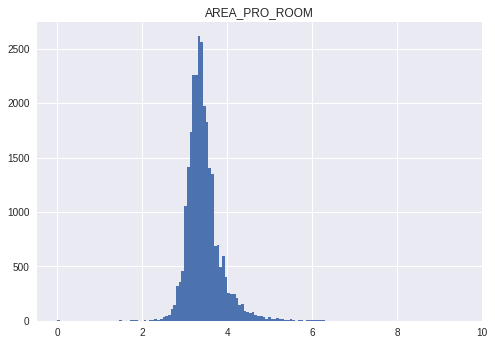

In [900]:
x_eval.hist("AREA_PRO_ROOM", bins = BINS)

In [901]:
y_eval.describe()

,PRICE_PRO_AREA
count,26918.000000
mean,7.524553
std,0.735995
min,1.776492
25%,7.130899
50%,7.562154
75%,7.957577
max,20.960654


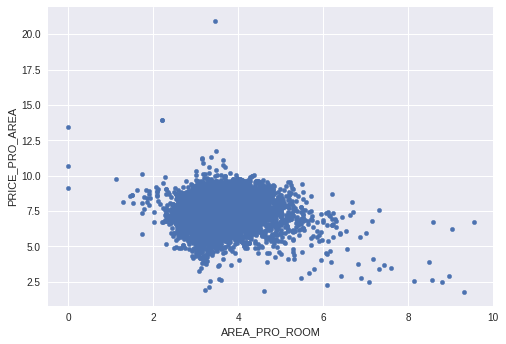

In [902]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [903]:
x_test.describe()

,AREA_PRO_ROOM
count,11536.000000
mean,3.455774
std,0.434678
min,0.000000
25%,3.218876
50%,3.392829
75%,3.610918
max,9.024011


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02a6f05748>]],
      dtype=object)

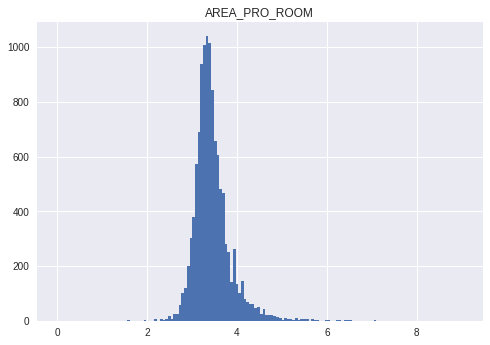

In [904]:
x_test.hist("AREA_PRO_ROOM", bins = BINS)

In [905]:
y_test.describe()

,PRICE_PRO_AREA
count,11536.000000
mean,7.523979
std,0.721412
min,1.845827
25%,7.128229
50%,7.559712
75%,7.966027
max,12.157282


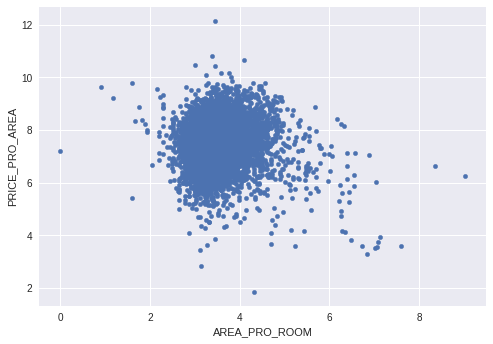

In [906]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [907]:
x_train.head()

,AREA_PRO_ROOM
10899,3.323236
191645,4.060443
100365,2.995732
144447,3.140914
120416,3.232121


In [908]:
x_eval.head()

,AREA_PRO_ROOM
212492,3.314186
73088,2.926739
30512,3.667826
70397,3.338139
210499,3.979682


In [909]:
x_test.head()

,AREA_PRO_ROOM
5,3.332205
78,3.401197
109,3.624341
128,3.344039
208,2.890372


In [910]:
y_train.head()

,PRICE_PRO_AREA
10899,7.026539
191645,6.580209
100365,7.522941
144447,8.426736
120416,7.706921


In [911]:
y_eval.head()

,PRICE_PRO_AREA
212492,7.859764
73088,7.199892
30512,7.615686
70397,8.191316
210499,8.357967


In [912]:
y_test.head()

,PRICE_PRO_AREA
5,7.666556
78,7.995194
109,8.444622
128,8.526561
208,7.619252


In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
 
    # Construct a dataset, and configure batching/repeating
    features = {key:np.array(value) for key,value in dict(features).items()} 
  
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
train_input_fn = lambda: input_fn(x_train, y_train)

In [0]:
train_predict_input_fn = lambda: input_fn(x_train, y_train, num_epochs=1, shuffle=False)

In [0]:
eval_predict_input_fn = lambda: input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

In [0]:
test_predict_input_fun = lambda: input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM") 
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [920]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplrmpkd0k', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f030e0e9400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
for period in range(0, PERIODS):
  model.train(input_fn=train_input_fn, steps=STEPS)
  train_predict = model.predict(input_fn=train_predict_input_fn)
  eval_predict = model.predict(input_fn=eval_predict_input_fn)
  print("-" * 100)
  model.evaluate(steps=STEPS, input_fn=train_predict_input_fn)
  model.evaluate(steps=STEPS, input_fn=eval_predict_input_fn) 
  print("-" * 100)
  
  train_predict = np.array([item['predictions'][0] for item in train_predict])
  eval_predict = np.array([item['predictions'][0] for item in eval_predict])
  
  # Compute loss for train and evaluation
  train_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(train_predict, y_train))
  eval_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(eval_predict, y_eval))
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplrmpkd0k/model.ckpt.
INFO:tensorflow:loss = 18.53359, step = 0
INFO:tensorflow:global_step/sec: 406.184
INFO:tensorflow:loss = 63.965603, step = 100 (0.251 sec)
INFO:tensorflow:global_step/sec: 448.957
INFO:tensorflow:loss = 59.461277, step = 200 (0.223 sec)
INFO:tensorflow:global_step/sec: 474.253
INFO:tensorflow:loss = 61.807526, step = 300 (0.207 sec)
INFO:tensorflow:global_step/sec: 499.908
INFO:tensorflow:loss = 67.452576, step = 400 (0.201 sec)
INFO:tensorflow:global_step/sec: 526.878
INFO:tensorflow:loss = 49.21928, step = 500 (0.191 sec)
INFO:tensorflow:global_step/sec: 545.251
INFO:tensorflow:loss = 51.826244, step = 600 (0.184 sec)
INFO:tensorflow:global_step/sec: 450.936
INFO:tensorflow:lo

INFO:tensorflow:global_step/sec: 436.621
INFO:tensorflow:loss = 74.1975, step = 2900 (0.228 sec)
INFO:tensorflow:global_step/sec: 408.45
INFO:tensorflow:loss = 44.185192, step = 3000 (0.245 sec)
INFO:tensorflow:global_step/sec: 430.85
INFO:tensorflow:loss = 49.5326, step = 3100 (0.232 sec)
INFO:tensorflow:global_step/sec: 431.715
INFO:tensorflow:loss = 59.2187, step = 3200 (0.233 sec)
INFO:tensorflow:global_step/sec: 438.124
INFO:tensorflow:loss = 60.195595, step = 3300 (0.225 sec)
INFO:tensorflow:global_step/sec: 438.943
INFO:tensorflow:loss = 51.192253, step = 3400 (0.228 sec)
INFO:tensorflow:global_step/sec: 387.412
INFO:tensorflow:loss = 28.352034, step = 3500 (0.258 sec)
INFO:tensorflow:global_step/sec: 440.965
INFO:tensorflow:loss = 49.76079, step = 3600 (0.230 sec)
INFO:tensorflow:global_step/sec: 425.883
INFO:tensorflow:loss = 58.589348, step = 3700 (0.234 sec)
INFO:tensorflow:global_step/sec: 438.165
INFO:tensorflow:loss = 28.465858, step = 3800 (0.229 sec)
INFO:tensorflow:glo

INFO:tensorflow:Saving dict for global step 5000: average_loss = 55.61325, global_step = 5000, loss = 55.61325
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmplrmpkd0k/model.ckpt-5000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-03-15:11:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplrmpkd0k/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [500/5000]
INFO:tensorflow:Evaluation [1000/5000]
INFO:tensorflow:Evaluation [1500/5000]
INFO:tensorflow:Evaluation [2000/5000]
INFO:tensorflow:Evaluation [2500/5000]
INFO:tensorflow:Evaluation [3000/5000]
INFO:tensorflow:Evaluation [3500/5000]
INFO:tensorflow:Evaluation [4000/5000]
INFO:tensorflow:Evaluation [4500/5000]
INFO:tensorflow:Evaluation [5000/5000]
INFO:tensorflow:Finished evaluation at 2018-08-03-15:11:35
INFO:tenso

INFO:tensorflow:loss = 52.8355, step = 5800 (0.255 sec)
INFO:tensorflow:global_step/sec: 443.209
INFO:tensorflow:loss = 71.32581, step = 5900 (0.222 sec)
INFO:tensorflow:global_step/sec: 433.756
INFO:tensorflow:loss = 68.278015, step = 6000 (0.236 sec)
INFO:tensorflow:global_step/sec: 427.361
INFO:tensorflow:loss = 70.71507, step = 6100 (0.231 sec)
INFO:tensorflow:global_step/sec: 429.249
INFO:tensorflow:loss = 52.893864, step = 6200 (0.234 sec)
INFO:tensorflow:global_step/sec: 393.317
INFO:tensorflow:loss = 65.32029, step = 6300 (0.254 sec)
INFO:tensorflow:global_step/sec: 443.522
INFO:tensorflow:loss = 42.499123, step = 6400 (0.225 sec)
INFO:tensorflow:global_step/sec: 438.035
INFO:tensorflow:loss = 43.61758, step = 6500 (0.227 sec)
INFO:tensorflow:global_step/sec: 434.144
INFO:tensorflow:loss = 40.248398, step = 6600 (0.230 sec)
INFO:tensorflow:global_step/sec: 439.781
INFO:tensorflow:loss = 29.298748, step = 6700 (0.227 sec)
INFO:tensorflow:global_step/sec: 407.275
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 404.717
INFO:tensorflow:loss = 46.796368, step = 9000 (0.247 sec)
INFO:tensorflow:global_step/sec: 432.897
INFO:tensorflow:loss = 49.904976, step = 9100 (0.229 sec)
INFO:tensorflow:global_step/sec: 441.974
INFO:tensorflow:loss = 39.213673, step = 9200 (0.226 sec)
INFO:tensorflow:global_step/sec: 458.649
INFO:tensorflow:loss = 65.73423, step = 9300 (0.221 sec)
INFO:tensorflow:global_step/sec: 446.896
INFO:tensorflow:loss = 53.03942, step = 9400 (0.220 sec)
INFO:tensorflow:global_step/sec: 407.389
INFO:tensorflow:loss = 41.68112, step = 9500 (0.249 sec)
INFO:tensorflow:global_step/sec: 434.991
INFO:tensorflow:loss = 47.129997, step = 9600 (0.229 sec)
INFO:tensorflow:global_step/sec: 437.98
INFO:tensorflow:loss = 51.583427, step = 9700 (0.227 sec)
INFO:tensorflow:global_step/sec: 441.891
INFO:tensorflow:loss = 68.39162, step = 9800 (0.229 sec)
INFO:tensorflow:global_step/sec: 426.497
INFO:tensorflow:loss = 49.01802, step = 9900 (0.231 sec)
INFO:tensorflow:

----------------------------------------------------------------------------------------------------
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplrmpkd0k/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
test_predict = model.predict(input_fn=test_predict_input_fun)
print("-" * 100)
model.evaluate(steps=STEPS, input_fn=test_predict_input_fun)
print("-" * 100)
test_predict = np.array([item['predictions'][0] for item in test_predict])  
test_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(test_predict, y_test))
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

In [0]:
test_predict = np.array([item["predictions"][0] for item in test_predict])

In [0]:
test_predict